## Reading the data

In [ ]:
# Importing the required packages
import warnings
warnings.filterwarnings("ignore")

import re

import pandas as pd

import matplotlib.pyplot as plt

from wordcloud import WordCloud

import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report , recall_score , f1_score , precision_score 

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Reading the dataset using pandas
def read_data():
    """
        Read the dataset using the pandas Dataframe

        Returns:
        -------
            twitter_data : pandas.DataFrame
    """
    twitter_df = pd.read_csv("Tweets.csv")
    return twitter_df

In [ ]:
# Calling the method read_data
twitter_data = read_data()

---

## Analysis of the data

In [ ]:
# Getting the columns and the datatypes of the columns
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [ ]:
# Looking at the data samples
twitter_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


---

### Cleaning and aligning the columns

In [ ]:
# Removing the non important columns for this analysis
twitter_data = twitter_data.drop(['tweet_id', 'name', 'tweet_coord', 'user_timezone', 'retweet_count'], axis=1)

In [ ]:
twitter_data['negativereason'] = twitter_data['negativereason'].fillna('Not defined')

In [ ]:
# Looking at the data samples after removal of the above columns
twitter_data.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,text,tweet_created,tweet_location
0,neutral,1.0000,Not defined,NaN,Virgin America,NaN,NaN,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN
1,positive,0.3486,Not defined,0.0000,Virgin America,NaN,NaN,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN
2,neutral,0.6837,Not defined,NaN,Virgin America,NaN,NaN,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play
3,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,NaN,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN
4,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,NaN,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN


In [ ]:
# Removing Unnecessary columns from the dataset
twitter_data.drop(['airline_sentiment_gold','negativereason_gold'], axis=1, inplace=True)

In [ ]:
# Converting the tweet_created field to a datetime object
twitter_data['tweet_created'] = pd.to_datetime(twitter_data['tweet_created'])

# Extracting the date and time components into separate columns
twitter_data['date_created'] = twitter_data['tweet_created'].dt.date
twitter_data['time_created'] = twitter_data['tweet_created'].dt.time

# Dropping the tweet_created columns
twitter_data.drop(['tweet_created'],axis=1, inplace=True)
twitter_data.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,text,tweet_location,date_created,time_created
0,neutral,1.0000,Not defined,NaN,Virgin America,@VirginAmerica What @dhepburn said.,NaN,2015-02-24,11:35:52
1,positive,0.3486,Not defined,0.0000,Virgin America,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24,11:15:59
2,neutral,0.6837,Not defined,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...,Lets Play,2015-02-24,11:15:48
3,negative,1.0000,Bad Flight,0.7033,Virgin America,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24,11:15:36
4,negative,1.0000,Can't Tell,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24,11:14:45


In [ ]:
#Re-arranging the columns  
twitter_data= twitter_data[['date_created','time_created','airline','airline_sentiment','airline_sentiment_confidence','negativereason','text','tweet_location']]
twitter_data.head()

,date_created,time_created,airline,airline_sentiment,airline_sentiment_confidence,negativereason,text,tweet_location
0,2015-02-24,11:35:52,Virgin America,neutral,1.0000,Not defined,@VirginAmerica What @dhepburn said.,NaN
1,2015-02-24,11:15:59,Virgin America,positive,0.3486,Not defined,@VirginAmerica plus you've added commercials t...,NaN
2,2015-02-24,11:15:48,Virgin America,neutral,0.6837,Not defined,@VirginAmerica I didn't today... Must mean I n...,Lets Play
3,2015-02-24,11:15:36,Virgin America,negative,1.0000,Bad Flight,@VirginAmerica it's really aggressive to blast...,NaN
4,2015-02-24,11:14:45,Virgin America,negative,1.0000,Can't Tell,@VirginAmerica and it's a really big bad thing...,NaN


### Cleaning the tweets

In [ ]:
twitter_data['text']

0                      @VirginAmerica What @dhepburn said.
1        @VirginAmerica plus you've added commercials t...
2        @VirginAmerica I didn't today... Must mean I n...
3        @VirginAmerica it's really aggressive to blast...
4        @VirginAmerica and it's a really big bad thing...
                               ...                        
14635    @AmericanAir thank you we got on a different f...
14636    @AmericanAir leaving over 20 minutes Late Flig...
14637    @AmericanAir Please bring American Airlines to...
14638    @AmericanAir you have my money, you change my ...
14639    @AmericanAir we have 8 ppl so we need 2 know h...
Name: text, Length: 14640, dtype: object

In [ ]:
# Removing the stopwords for more clarity
sw_nltk = stopwords.words('english')
airlines = list(set(twitter_data['airline'].apply(lambda x : x.lower().replace(' ','')).values))
some_words = ["southwestair", "jetblue", "americanair", "flight", "plane", "amp", "thank", "thanks", "u"]
removed_words = sw_nltk + airlines + some_words

In [ ]:
# General cleaning with regex for removal of unwanted characters
def clean_tweets(str):
    str = str.lower()
    str = (re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", str))
    str = (re.sub('[^A-Za-z ]',' ', str))
    str = word_tokenize(str)
    str = ' '.join([word for word in str if word not in removed_words])
    return str

In [ ]:
# Appying the tweet cleaning to the data from the dataframe
cleaned_tweets = list()
for idx, rows in twitter_data.iterrows():
    text = str(rows['text'])
    cleaned_text = clean_tweets(text)
    cleaned_tweets.append(cleaned_text)
twitter_data['text'] = cleaned_tweets

In [ ]:
twitter_data['text']

0                                            dhepburn said
1                  plus added commercials experience tacky
2                   today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                                got different chicago
14636    leaving minutes late warnings communication mi...
14637                     please bring airlines blackberry
14638    money change answer phones suggestions make co...
14639    ppl need know many seats next plz put us stand...
Name: text, Length: 14640, dtype: object

---

### General Analysis of the Data

In [ ]:
#Unique airlines available in the data
unique_airline = twitter_data['airline'].unique()
print(f"The Unique Airlines in the dataset are as follows:{unique_airline}")

The Unique Airlines in the dataset are as follows:['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']


Let's plot these for a better understanding of the distribution of the data

<AxesSubplot: title={'center': 'Total Tweets on Each Airline'}, ylabel='airline'>

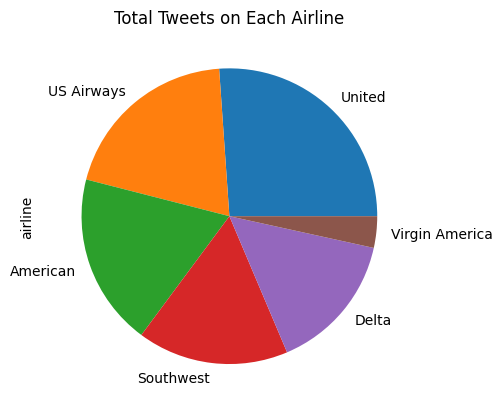

In [ ]:
#Tweets on each airline
airline_counts = twitter_data['airline'].value_counts()
#plot
airline_counts.plot.pie(title='Total Tweets on Each Airline')

<Figure size 1000x2000 with 0 Axes>

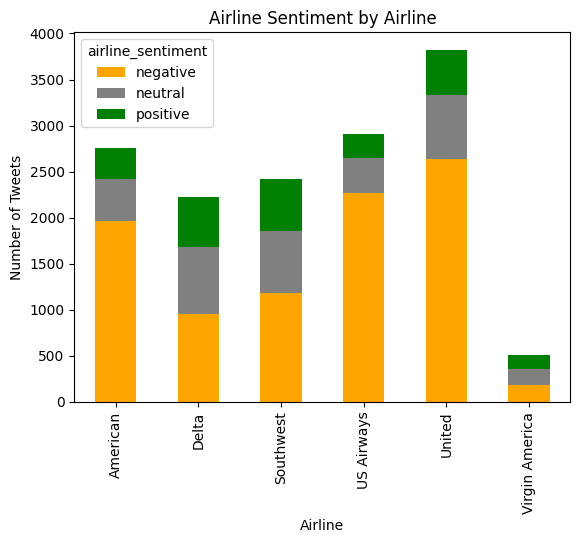

In [ ]:
grouped_data = twitter_data.groupby(['airline', 'airline_sentiment']).size().unstack()

fig = plt.figure(figsize = (10,20))
grouped_data.plot(kind='bar', stacked=True, color=["Orange", "grey", "Green"])
plt.title('Airline Sentiment by Airline')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.show()

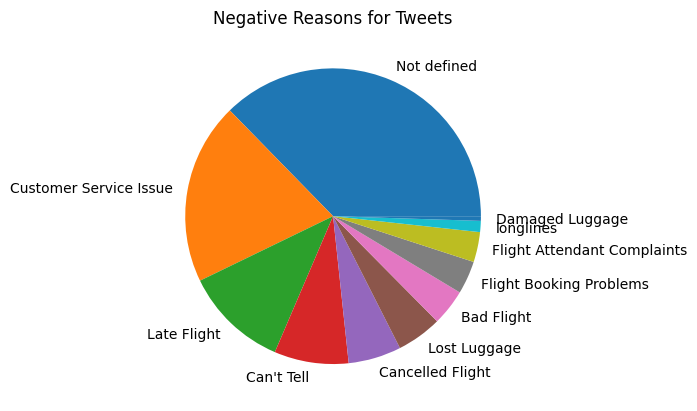

In [ ]:
reason_counts = twitter_data['negativereason'].value_counts()

plt.pie(reason_counts, labels=reason_counts.index)
plt.title('Negative Reasons for Tweets')
plt.show()

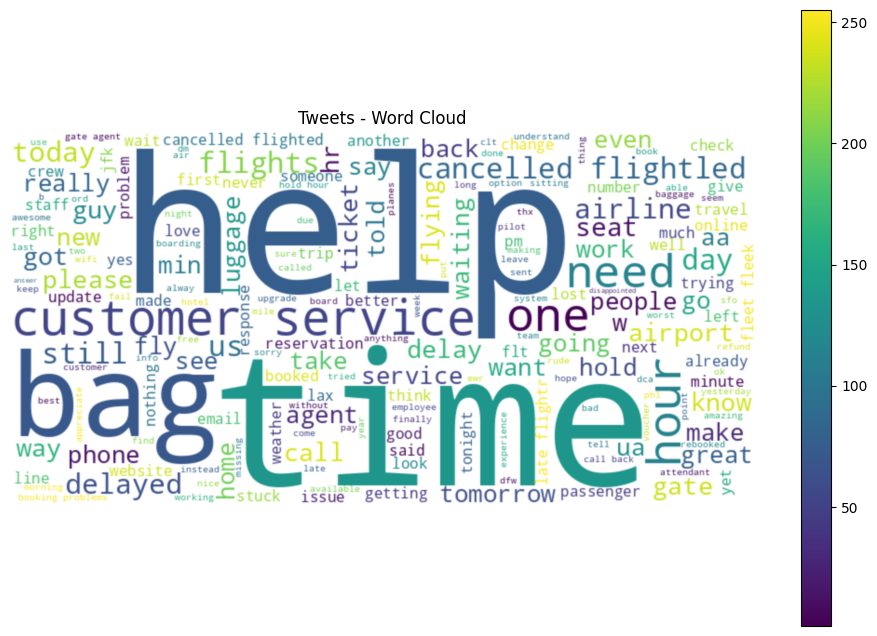

In [ ]:
# Combine all text into one string
text = ' '.join(twitter_data['text'].tolist())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot word cloud
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bicubic')
plt.colorbar()
plt.title("Tweets - Word Cloud")
plt.axis('off')
plt.show()

In [ ]:
# Defining the number of topics
num_of_topics = 10

# Creating instance for the LDA model with the number of topics 
lda_model = LatentDirichletAllocation(n_components=num_of_topics, random_state=42)

# Converting the text to vectors using Count Vectorizer
vectorizer = CountVectorizer(stop_words="english")
document_term = vectorizer.fit_transform(twitter_data['text'])

# Fitting the LDA model
lda_model.fit(document_term)

LatentDirichletAllocation(random_state=42)

In [ ]:
# print the topics and their top keywords
for index, topic in enumerate(lda_model.components_):
    print(f"Top  words for topic #{index}:")
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-6:]])
    print('\n')

Top  words for topic #0:
['hour', 'bags', 'gate', 'hours', 'minutes', 'waiting']


Top  words for topic #1:
['appreciate', 'time', 'fly', 'hours', 'response', 'hold']


Top  words for topic #2:
['flighted', 'tomorrow', 'delayed', 'flights', 'flightled', 'cancelled']


Top  words for topic #3:
['wait', 'make', 'time', 'booking', 'day', 'problems']


Top  words for topic #4:
['seats', 'class', 'time', 'fleet', 'fleek', 'seat']


Top  words for topic #5:
['online', 'email', 'number', 'phone', 'need', 'help']


Top  words for topic #6:
['good', 'crew', 'flt', 'sent', 'great', 'dm']


Top  words for topic #7:
['like', 'experience', 'airline', 'worst', 'customer', 'service']


Top  words for topic #8:
['airport', 'hours', 'lost', 'customer', 'service', 'bag']


Top  words for topic #9:
['going', 'new', 'home', 'guys', 'flightr', 'late']




---

### Missing Values counts

In [ ]:
# Finding the missing values from the data
def missing_values(twitter_data):
    """
        Missing Value counts for the data

        Parameters:
        ----------
            twitter_data : pandas.DataFrame
        
        Returns:
        --------
            missing_value_counts : dict
    """
    missing_value_counts = {key: int() for key in twitter_data.columns}
    for idx, column_name in enumerate(twitter_data.columns):
        missing_value_counts[column_name] = dict(twitter_data[column_name].isna().value_counts()).get(True, 0)

    return missing_value_counts

In [ ]:
# Calling the method missing_values
missing_values(twitter_data)

{'date_created': 0,
 'time_created': 0,
 'airline': 0,
 'airline_sentiment': 0,
 'airline_sentiment_confidence': 0,
 'negativereason': 0,
 'text': 0,
 'tweet_location': 4733}

From the missing values analysis, we observed that some columns such as 'negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'negativereason_gold', and 'tweet_location' have missing values. However, the two columns that are essential for training the model, i.e., 'text' and 'airline_sentiment', do not have any missing values.

---

### Class Imbalance Check

In [ ]:
# Checking for class imbalance for the target values
def class_imbalance_check(twitter_data):
    """
        Class imbalance check for the target values

        Paramters:
        ---------
        twitter_data : pandas.DataFrame

        Returns:
        -------
        class_value_counts : pandas.core.series.Series
    """
    class_value_counts = twitter_data['airline_sentiment'].value_counts()
    return class_value_counts

In [ ]:
# Calling the method class_imbalance_check
class_value_counts = class_imbalance_check(twitter_data)

In [ ]:
# Seeing the imbalances in the class
print(f"Tweets with class value of \"positive\": {class_value_counts['positive']}")
print(f"Tweets with class value of \"neutral\": {class_value_counts['neutral']}")
print(f"Tweets with class value of \"negative\": {class_value_counts['negative']}")

Tweets with class value of "positive": 2363
Tweets with class value of "neutral": 3099
Tweets with class value of "negative": 9178


Let's plot these values for more clear understanding.

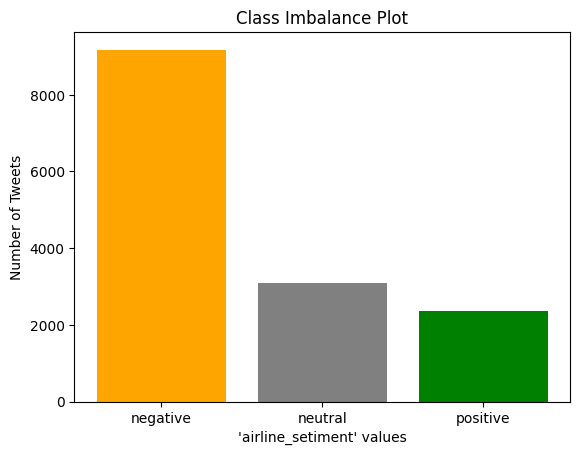

In [ ]:
# Plotting the 'airline_sentiment' value counts
plt.bar(class_value_counts.index, class_value_counts.values, color=['orange', 'gray', 'green'])
plt.xlabel('\'airline_setiment\' values')
plt.ylabel('Number of Tweets')
plt.title('Class Imbalance Plot')
plt.show()

*As we can see here, the `negative` class has significantly more instances, when compared to the other two class. Training with this data and calculating the accuracy on the model, will not give proper representation of what we are trying to achieve*

### Predictor attribute & Target Attribute

In [ ]:
# Splitting the data into X and y
X = twitter_data[['text']]
y = twitter_data['airline_sentiment']

In [ ]:
X.iloc[1,:]

text    plus added commercials experience tacky
Name: 1, dtype: object

## Handling Class Imbalance

### 1. Random Under Sampling

Undersampling refers to a technique of reducing the number of observations in the majority class to balance the class distribution with the minority class. It involves removing some of the data points in the majority class until the number of observations in both classes becomes comparable.

In [ ]:
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X, y)

In [ ]:
print("-"*50)
print(f"Original Class Values:\n{y.value_counts()}")
print("-"*50)
print(f"Under Sampled - Class Values:\n{y_rus.value_counts()}")
print("-"*50)

--------------------------------------------------
Original Class Values:
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
--------------------------------------------------
Under Sampled - Class Values:
positive    2363
neutral     2363
negative    2363
Name: airline_sentiment, dtype: int64
--------------------------------------------------


### 2. Random Over Sampling

Oversampling is a method of increasing the number of instances in the minority class by creating additional copies of the existing data points. It is a suitable approach in cases where there is insufficient data available to build a model that can accurately capture the minority class.

In [ ]:
ros = RandomOverSampler(random_state=42)# fit predictor and target variable
x_ros, y_ros = ros.fit_resample(X, y)

In [ ]:
print("-"*50)
print(f"Original Class Values:\n{y.value_counts()}")
print("-"*50)
print(f"Under Sampled - Class Values:\n{y_ros.value_counts()}")
print("-"*50)

--------------------------------------------------
Original Class Values:
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
--------------------------------------------------
Under Sampled - Class Values:
positive    9178
neutral     9178
negative    9178
Name: airline_sentiment, dtype: int64
--------------------------------------------------


## Experimental setups and training

In [ ]:
class ModelTraining(object):
    """
        A class for the model training
    """
    def __init__(self, X, y, method):
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        self.method = method
        if method == "rf":
            self.model = RandomForestClassifier(n_estimators=200)
        elif method == "svc":
            self.model = SVC()
        elif method == "bagging":
            self.model = BaggingClassifier()
        elif method == "nb":
            self.model = MultinomialNB()

    def tfid_vectorizer(self):
        self.tfid_vectorizer = TfidfVectorizer(stop_words='english')
        self.train_features = self.tfid_vectorizer.fit_transform(self.X_train['text'])
        self.test_features = self.tfid_vectorizer.transform(self.X_test['text'])
    
    def fit(self):
        self.tfid_vectorizer()
        return self.model.fit(self.train_features, self.y_train)

    def predict(self):
        self.predictions = self.model.predict(self.test_features)
        return self.predictions

    def accuracy(self):
        return accuracy_score(self.y_test, self.predictions)

    def classification_rprt(self):
        return classification_report(self.y_test, self.predictions)

    def model_metrics(self):
        return [(precision_score(self.y_test , self.predictions , average='micro')) , \
        (recall_score(self.y_test , self.predictions , average='micro')) , \
        (f1_score(self.y_test , self.predictions , average='micro'))]
        

# Random Forest Classifier

In [ ]:
rf_imb = ModelTraining(X, y, "rf")

In [ ]:
rf_imb.fit()
rf_imb.predict()
print(rf_imb.accuracy())

0.7346311475409836


In [ ]:
clss_rpt = rf_imb.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.80      0.89      0.84      1889
     neutral       0.58      0.41      0.48       580
    positive       0.55      0.51      0.53       459

    accuracy                           0.73      2928
   macro avg       0.64      0.60      0.62      2928
weighted avg       0.72      0.73      0.72      2928



In [ ]:
pre , rcl , f1 = rf_imb.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.7346311475409836
Recall = 0.7346311475409836
f1-score = 0.7346311475409836


# SVC

In [ ]:
sv_imb = ModelTraining(X, y, "svc")

In [ ]:
sv_imb.fit()
sv_imb.predict()
print(sv_imb.accuracy())

0.7612704918032787


In [ ]:
clss_rpt = sv_imb.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.77      0.96      0.85      1889
     neutral       0.71      0.35      0.47       580
    positive       0.76      0.45      0.57       459

    accuracy                           0.76      2928
   macro avg       0.75      0.59      0.63      2928
weighted avg       0.75      0.76      0.73      2928



In [ ]:
pre , rcl , f1 = sv_imb.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.7612704918032787
Recall = 0.7612704918032787
f1-score = 0.7612704918032787


# Bagging Classifier

In [ ]:
bc_imb = ModelTraining(X, y, "bagging")

In [ ]:
bc_imb.fit()
bc_imb.predict()
print(bc_imb.accuracy())

0.719603825136612


In [ ]:
clss_rpt = bc_imb.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.80      0.87      0.83      1889
     neutral       0.56      0.39      0.46       580
    positive       0.51      0.53      0.52       459

    accuracy                           0.72      2928
   macro avg       0.62      0.60      0.60      2928
weighted avg       0.71      0.72      0.71      2928



In [ ]:
pre , rcl , f1 = bc_imb.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.719603825136612
Recall = 0.719603825136612
f1-score = 0.719603825136612


# Multinomial Naive Bayes

In [ ]:
nb_imb = ModelTraining(X, y, "nb")

In [ ]:
nb_imb.fit()
nb_imb.predict()
print(nb_imb.accuracy())

0.6953551912568307


In [ ]:
clss_rpt = nb_imb.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.69      0.99      0.81      1889
     neutral       0.76      0.16      0.27       580
    positive       0.92      0.15      0.26       459

    accuracy                           0.70      2928
   macro avg       0.79      0.44      0.45      2928
weighted avg       0.74      0.70      0.62      2928



In [ ]:
pre , rcl , f1 = nb_imb.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.6953551912568307
Recall = 0.6953551912568307
f1-score = 0.6953551912568307


### Training and testing  - RUS - Random Forest Classifier

In [ ]:
rf_rus = ModelTraining(x_rus, y_rus, "rf")

In [ ]:
rf_rus.fit()

SVC()

In [ ]:
rf_rus.predict()

array(['neutral', 'positive', 'negative', ..., 'neutral', 'positive',
       'negative'], dtype=object)

In [ ]:
rf_rus.accuracy()

0.7595204513399154

In [ ]:
clss_rpt = rf_rus.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79       487
     neutral       0.72      0.76      0.74       476
    positive       0.77      0.74      0.75       455

    accuracy                           0.76      1418
   macro avg       0.76      0.76      0.76      1418
weighted avg       0.76      0.76      0.76      1418



In [ ]:
pre , rcl , f1 = rf_rus.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.7595204513399154
Recall = 0.7595204513399154
f1-score = 0.7595204513399155


### Training and Testing - ROS - Random Forest Classifier

In [ ]:
rf_ros = ModelTraining(x_ros, y_ros, "rf")

In [ ]:
rf_ros.fit()

RandomForestClassifier(n_estimators=200)

In [ ]:
rf_ros.predict()

array(['neutral', 'positive', 'negative', ..., 'negative', 'neutral',
       'negative'], dtype=object)

In [ ]:
rf_ros.accuracy()

0.90666424550572

In [ ]:
clss_rpt = rf_ros.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.95      0.83      0.88      1895
     neutral       0.88      0.92      0.90      1786
    positive       0.89      0.98      0.93      1826

    accuracy                           0.91      5507
   macro avg       0.91      0.91      0.91      5507
weighted avg       0.91      0.91      0.91      5507



In [ ]:
pre , rcl , f1 = rf_ros.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.90666424550572
Recall = 0.90666424550572
f1-score = 0.90666424550572


### Training and Testing - RUS - SVC

In [ ]:
svc_rus = ModelTraining(x_rus, y_rus, "svc")

In [ ]:
svc_rus.fit()

SVC()

In [ ]:
svc_rus.predict()

array(['neutral', 'positive', 'negative', ..., 'neutral', 'positive',
       'negative'], dtype=object)

In [ ]:
svc_rus.accuracy()

0.7595204513399154

In [ ]:
clss_rpt = svc_rus.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79       487
     neutral       0.72      0.76      0.74       476
    positive       0.77      0.74      0.75       455

    accuracy                           0.76      1418
   macro avg       0.76      0.76      0.76      1418
weighted avg       0.76      0.76      0.76      1418



In [ ]:
pre , rcl , f1 = svc_rus.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.7595204513399154
Recall = 0.7595204513399154
f1-score = 0.7595204513399155


### Training and Testing - ROS - SVC

In [ ]:
svc_ros = ModelTraining(x_ros, y_ros, "svc")

In [ ]:
svc_ros.fit()

SVC()

In [ ]:
svc_ros.predict()

array(['neutral', 'positive', 'negative', ..., 'negative', 'neutral',
       'negative'], dtype=object)

In [ ]:
svc_ros.accuracy()

0.9164699473397494

In [ ]:
clss_rpt = svc_ros.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.93      0.89      0.91      1895
     neutral       0.89      0.90      0.90      1786
    positive       0.93      0.96      0.95      1826

    accuracy                           0.92      5507
   macro avg       0.92      0.92      0.92      5507
weighted avg       0.92      0.92      0.92      5507



In [ ]:
pre , rcl , f1 = svc_ros.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.9164699473397494
Recall = 0.9164699473397494
f1-score = 0.9164699473397495


### Training and Testing - RUS - BaggingClassifier

In [ ]:
bag_rus = ModelTraining(x_rus, y_rus, "bagging")

In [ ]:
bag_rus.fit()

BaggingClassifier()

In [ ]:
bag_rus.predict()

array(['negative', 'positive', 'negative', ..., 'neutral', 'positive',
       'negative'], dtype=object)

In [ ]:
bag_rus.accuracy()

0.6960507757404796

In [ ]:
clss_rpt = bag_rus.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.72      0.74      0.73       487
     neutral       0.68      0.72      0.70       476
    positive       0.69      0.62      0.65       455

    accuracy                           0.70      1418
   macro avg       0.70      0.69      0.69      1418
weighted avg       0.70      0.70      0.70      1418



In [ ]:
pre , rcl , f1 = bag_rus.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.6960507757404796
Recall = 0.6960507757404796
f1-score = 0.6960507757404796


### Training and Testing - ROS - BaggingClassifier

In [ ]:
bag_ros = ModelTraining(x_ros, y_ros, "bagging")

In [ ]:
bag_ros.fit()

BaggingClassifier()

In [ ]:
bag_ros.predict()

array(['neutral', 'positive', 'negative', ..., 'negative', 'neutral',
       'negative'], dtype=object)

In [ ]:
bag_ros.accuracy()

0.8810604684946431

In [ ]:
clss_rpt = bag_ros.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.95      0.76      0.84      1895
     neutral       0.85      0.91      0.88      1786
    positive       0.86      0.97      0.92      1826

    accuracy                           0.88      5507
   macro avg       0.89      0.88      0.88      5507
weighted avg       0.89      0.88      0.88      5507



In [ ]:
pre , rcl , f1 = bag_ros.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.8810604684946431
Recall = 0.8810604684946431
f1-score = 0.8810604684946431


### Training and Testing - RUS - Multinomial Naive Bayes

In [ ]:
nb_rus = ModelTraining(x_rus, y_rus, "nb")

In [ ]:
nb_rus.fit()

MultinomialNB()

In [ ]:
nb_rus.predict()

array(['neutral', 'positive', 'negative', ..., 'neutral', 'positive',
       'negative'], dtype='<U8')

In [ ]:
nb_rus.accuracy()

0.734132581100141

In [ ]:
clss_rpt = nb_rus.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.73      0.82      0.77       487
     neutral       0.72      0.65      0.68       476
    positive       0.75      0.73      0.74       455

    accuracy                           0.73      1418
   macro avg       0.73      0.73      0.73      1418
weighted avg       0.73      0.73      0.73      1418



In [ ]:
pre , rcl , f1 = nb_rus.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.734132581100141
Recall = 0.734132581100141
f1-score = 0.734132581100141


### Training and Testing - ROS - Multinomial Naive Bayes

In [ ]:
nb_ros = ModelTraining(x_ros, y_ros, "nb")

In [ ]:
nb_ros.fit()

MultinomialNB()

In [ ]:
nb_ros.predict()

array(['neutral', 'neutral', 'negative', ..., 'negative', 'neutral',
       'negative'], dtype='<U8')

In [ ]:
nb_ros.accuracy()

0.8017069184674052

In [ ]:
clss_rpt = nb_ros.classification_rprt()
print(clss_rpt)

              precision    recall  f1-score   support

    negative       0.83      0.82      0.82      1895
     neutral       0.74      0.80      0.77      1786
    positive       0.84      0.79      0.82      1826

    accuracy                           0.80      5507
   macro avg       0.80      0.80      0.80      5507
weighted avg       0.80      0.80      0.80      5507



In [ ]:
pre , rcl , f1 = nb_ros.model_metrics()
print('Precision = {}'.format(pre))
print('Recall = {}'.format(rcl))
print('f1-score = {}'.format(f1))

Precision = 0.8017069184674052
Recall = 0.8017069184674052
f1-score = 0.8017069184674052


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ab0cbed-4085-4e11-9472-2e1e052d4aca' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>